In [31]:
import torch
class a_opt(torch.optim.lr_scheduler.LRScheduler):
    def __init__(self, x):
        pass
        
model = torch.nn.LSTM(100, 100)
c = a_opt(torch.optim.AdamW(model.parameters(), lr=0.1))
isinstance(c, torch.optim.lr_scheduler.LRScheduler)

KeyboardInterrupt: 

In [ ]:
import torch
class outProd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, branch, trunk):
        b, p = branch.shape[0], trunk.shape[0]
        branch = branch.expand(b, p)
        trunk = trunk.expand(b, p)
        ctx.save_for_backward(branch, trunk)
        return branch * trunk
    @staticmethod
    def backward(ctx, grad_output):
        branch, trunk = ctx.saved_tensors
        grad_input = grad_output.clone()
        print(grad_input.shape, branch.shape, trunk.shape)
        branch_grad = grad_input * trunk
        trunk_grad = grad_input * branch
        print(branch_grad.shape, trunk_grad.shape)
        return branch_grad, trunk_grad


x = torch.ones(10, 1)
y = torch.linspace(0, 1, 10)[...,None].requires_grad_()
a = outProd.apply(x,y)
print(a)
torch.autograd.grad(a, y, grad_outputs= torch.ones_like(a),retain_graph=True)

In [ ]:
x = torch.ones(10, 1)
y = torch.linspace(0, 1, 10)[None,...].requires_grad_()
a = torch.outer(x, y)

In [ ]:
a = torch.ones(10, 10)
b = torch.linspace(0, 1, 10)[None,...]
print(a * b)

In [ ]:
import torch.nn as nn
class originDeepONetCard(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(1, 10)
        self.trunk = nn.Linear(1, 10)
    def forward(self, x):
        branch = self.branch(x[0])
        trunk = self.trunk(x[1])
        out = torch.einsum("b i, p i -> b p", branch, trunk)
        return out
    
class DeepONetCard(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(1, 10)
        self.trunk = nn.Linear(1, 10)
    def forward(self, x):
        p, b = x[1].shape[0], x[0].shape[0]
        branch = self.branch(x[0])
        trunk = self.trunk(x[1])
        branch = branch.unsqueeze(1).expand(b, p, 10)
        trunk = trunk.unsqueeze(0).expand(b, p, 10)
        return (branch * trunk).sum(-1)
    
netA = originDeepONetCard()
netB = DeepONetCard()
a = torch.ones(10, 1)
b = torch.linspace(0, 1, 10)[..., None].requires_grad_()
x = (a, b)
A = netA(x)
B = netB(x)
print(torch.autograd.grad(A, b, grad_outputs= torch.ones_like(A),retain_graph=True)[0])
print(torch.autograd.grad(B, b, grad_outputs= torch.ones_like(B),retain_graph=True)[0])

In [ ]:
import torch
from torch import nn
import time
class net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        return self.a(x)

y = net()
a = torch.randn(1, 10, requires_grad=True)
a = a.expand(1000, 10)
b = a.mean(0, keepdim=True)
t_K = y(a)
print(t_K.shape)
grad_batched = torch.eye(1000)[...,None]
grad = torch.autograd.grad(t_K, a, grad_outputs= grad_batched,retain_graph=True, is_grads_batched=True)[0]
print(grad)
for i in y.parameters():
    print(i)

In [ ]:
import torch
from torch import nn
import time
class DeepOnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch = nn.Linear(10, 10)
        self.trunk = nn.Sequential(nn.Linear(1, 100), nn.Linear(100,10))
    
    def forward(self, b, t, mode = "a"):
        if mode == "a":
            branch = self.branch(b)
            trunk = self.trunk(t)
            return torch.einsum("b i, p i -> b p", branch, trunk)
        else:
            t = t.mean(0) # p, 1
            branch = self.branch(b) # b, 10
            trunk = self.trunk(t) # p, 10
            return torch.einsum("b i, p i -> b p", branch, trunk)

batch = 600
y = DeepOnet().cuda()
trunk_inp = torch.randn(1000, 1, requires_grad=True, device="cuda")
branch_inp = torch.randn(batch, 10, requires_grad=True, device="cuda")
t_K = y(branch_inp, trunk_inp, mode="a")

# 1000 x 1000 x 1; b, p, 1

In [ ]:
torch.cuda.empty_cache()
t = time.time()
grad2 = []
for i in t_K:
    grad2.append(torch.autograd.grad(i, trunk_inp, grad_outputs= torch.ones_like(i),retain_graph=True, create_graph=True)[0])
grad2 = torch.stack(grad2)
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad2.shape)
#print(grad2)
print(time.time() - t)

In [ ]:
torch.cuda.empty_cache()
t = time.time()
for i in range(1):
    t_K = y(branch_inp, trunk_inp, mode="a")

grad_batched = torch.eye(batch, device = "cuda")[...,None].expand(batch, batch, 1000)
print(grad_batched.shape, t_K.shape)
grad3 = torch.autograd.grad(t_K, trunk_inp, grad_outputs= grad_batched,retain_graph=True, is_grads_batched= True, create_graph=True)[0]
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad3.shape)

print(time.time() - t)

In [ ]:
import torch
import deepxde.deepxde as dde
import time

net = dde.nn.pytorch.DeepONetCartesianProd([101, 100, 100], [2, 100, 100], "gelu", "Glorot normal")

batch = 50
branch = torch.randn(batch, 101)
trunk = torch.randn(10000, 2).requires_grad_()

result = net((branch, trunk))

In [ ]:
t = time.time()
grad2 = []
for i in result:
    grad2.append(torch.autograd.grad(i, trunk, grad_outputs= torch.ones_like(i),retain_graph=True, create_graph=True)[0])
grad2 = torch.stack(grad2)
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad2.shape)
#print(grad2)
print(time.time() - t)

In [ ]:
t = time.time()
grad_batched = torch.eye(batch, device = "cuda")[...,None].expand(batch, batch, 10000)
grad3 = torch.autograd.grad(result, trunk, grad_outputs= grad_batched,retain_graph=True, is_grads_batched= True, create_graph=True)[0]
print(torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated())
print(grad3.shape)

print(time.time() - t)

In [ ]:
print((grad2 - grad3 > 1e-6).sum())

In [ ]:
import deepxde.deepxde as dde
import numpy as np
f = dde.data.GRF(length_scale=0.1)
fea = f.random(1)
func = f.eval_batch(fea, np.linspace(0, 1, 101)[:, None])
func = np.ones((1, 101))
from datasets.solver import advection_solver
xt, u = advection_solver(func)

import matplotlib.pyplot as plt
fig , (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(np.linspace(0, 1, 101), func[0])
print(u[0])
xt2 = xt.reshape(-1, 2)
u2 = u.reshape(-1, 1)
ax2.scatter(xt2[:, 0], xt2[:, 1], c = u2)


In [ ]:
u.T[0]

In [ ]:
import torch

stat = torch.load("./results/adr_H1_norm_GRF_norm_19.pth")
print(stat.keys())

In [ ]:
stat = torch.load("./results/adr_pial_300000.pth")
print(stat.keys())

In [ ]:
print(stat['trunk.linears.0.weight'].shape)
print(stat['branch.linears.0.weight'].shape)

In [ ]:
import deepxde.deepxde as dde
import numpy as np
import torch
from datasets import solver

def periodic(x):
    # print( "shape",torch.sin(x[:, 0] * 2 * np.pi).shape)
    return torch.cat((torch.cos(x[:, 0] * 2 * np.pi).reshape(-1, 1), torch.sin(x[:, 0] * 2 * np.pi).reshape(-1, 1),
                      torch.cos(2 * x[:, 0] * 2 * np.pi).reshape(-1, 1), torch.sin(2 * x[:, 0] * 2 * np.pi).reshape(-1, 1), x[:, 1].reshape(-1, 1)), 1)

fsp = dde.data.GRF(length_scale = 0.05)
fea = fsp.random(1)
vx = fsp.eval_batch(fea, np.linspace(0, 1, 100))

net = dde.nn.DeepONetCartesianProd(
    [100, 100, 100],
    [5, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

net.apply_feature_transform(periodic)

net.load_state_dict(stat, strict = False)
print(vx.shape)
xt, u = solver.diffusion_reaction_solver(vx[0], Nx = 100, Nt = 100)
print(xt.shape)
print(u.shape)



geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

xt_uniform = xt.reshape(-1, 2)
#xt_uniform = geomtime.uniform_points(10000)
inputs = (torch.as_tensor(vx), torch.as_tensor(xt_uniform).float())
# print(inputs[0], inputs[1])
up = net(inputs)

In [ ]:
print(u.shape, up.shape)
u_p = up[0].detach().cpu().numpy()
u_t = u.flatten()
print(u_p.shape, u_t.shape)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.scatter(np.linspace(0, 1, 100), vx[0])
ax2.scatter(x = xt_uniform[:, 0], y = xt_uniform[:, 1], c = u_t)
ax3.scatter(x = xt_uniform[:, 0], y = xt_uniform[:, 1], c = u_p)
ax1.set_title("vx")
ax1.set_xlim(0, 1)
ax2.set_aspect("equal")
ax3.set_aspect("equal")
ax4.set_aspect("equal")
plt.tight_layout()
plt.show()


In [ ]:
from utils.test_model import normONet
import torch
from torch import nn
t = torch.randn(10000, 2)
b = torch.randn(100, 101)

net = normONet()

net((t, b))

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import torch
import numpy as np
import time

def solve_CVC(xmin: float, xmax: float, tmin: float, tmax: float, v: np.ndarray, g, f, Nx: int,  Nt: int,  upsample: int = 5):
    # Create grid
    Mx, Mt = (Nx - 1) * upsample + 1, (Nt - 1) * upsample + 1
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    X = np.linspace(0, xmax, Mx)
    T = np.linspace(0, tmax, Mt)
    # print(X.shape, v.shape)
    h = X[1] - X[0]
    dt = T[1] - T[0]
    lam = dt / h
    
    # Computer advection velocity
    vn = np.interp(X, x, v.flatten())
    
    # Initialize solution and apply initial & boundary conditions
    u = np.zeros((Mx, Mt))
    u[0, :] = g(T)
    u[:, 0] = f(X)
    
    # Compute finite difference operators
    mid = (vn[:-1] + vn[1:]) / 2
    k = (1 - mid * lam) / (1 + mid * lam)
    K = np.eye(Mx - 1, k = 0)
    K_temp = np.eye(Mx - 1, k = 0)
    Trans = np.eye(Mx - 1, k = -1)
    
    tv = torch.from_numpy(k)
    l = tv.shape[0]
    t_K = torch.ones((l,l)).tril()
    _ = [t_K[...,i:,:i].mul_(-tv[i]) for i in range(1, l)]
    
    def body_fn_x(i, carry):
        K, K_temp = carry
        K_temp = (-k[:, None] * (Trans @ K_temp))
        K += K_temp
        return K, K_temp
    
    for i in range(Mx - 2):
        K, K_temp = body_fn_x(i, (K, K_temp))
    
    
    D = np.diag(k) + np.eye(Mx - 1, k=-1)
    t_D = torch.from_numpy(D).float()
    tg = lambda t: (t * torch.pi).sin()
    t = torch.linspace(0, 1, 501)
    gt = tg(t)    
    t_B = gt[:-1] - gt[1:] * tv[0]
    
    z = torch.zeros(500, 500)
    z[:,0] = t_B
    t_B = z
    t = time.time()
    outu = torch.empty((501, 501))
    outu[0] = (torch.linspace(0, 1, 501) * torch.pi).sin()
    outu[:,0] = (torch.linspace(0, 1, 501) * torch.pi / 2).sin()
    viu = outu[1:]
    print("K check:", ((t_K.numpy() - K) < 1e-5).all())
    print("D check:", ((t_D.numpy() - D) < 1e-5).all())
    for i in range(0, Mt - 1):
        b = np.zeros(Mx - 1)
        b[0] = g(i * dt) - k[0] * g((i + 1) * dt)
        tb = t_B[i]
        #print(t_B[i,0], b[0])
        print("B check:", ((b - tb.numpy()) < 1e-5).all())
        buf = K @ (D @ u[1:, i] + b)
        
        ch = t_K @ (t_D @ viu[:, i] + t_B[i])
        # print((buf - ch.numpy() < 1e-5))
        u[1:, i + 1] = buf
        viu[:, i + 1] = ch
        print("U check:", ((u[1:, i] - viu[:, i].numpy()) < 1e-5).all())
        
    UU = u[::upsample, ::upsample]
    t_UU = outu[::upsample, ::upsample]
    print("solution check:", ((t_UU.numpy() - UU) < 1e-5).all())
    
    return x, t, UU

v = np.random.randn(101)
v = np.abs(v) + 0.5

t = time.time()
_, _, u = solve_CVC(0, 1, 0, 1, v, lambda t: np.sin(t * np.pi), lambda x: np.sin(x * np.pi / 2), 101, 101)
print(u.shape)
print(time.time() - t)

In [ ]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from typing import Callable
from numpy.typing import ArrayLike
import numpy as np
import time

class CVCSolver(nn.Module):
    def __init__(self, xmin: float = 0, xmax: float = 1, tmin: float = 0, tmax: float = 1, Nx: int = 101, Nt: int = 101, upsample: int = 5):
        super().__init__()
        self.xmin = xmin
        self.xmax = xmax
        self.tmin = tmin
        self.tmax = tmax
        self.Nx = Nx
        self.Nt = Nt
        self.upsample = upsample
        self.Mx = (Nx - 1) * upsample + 1
        self.Mt = (Nt - 1) * upsample + 1
        self.register_buffer("xgrid", torch.linspace(xmin, xmax, Nx))
        self.register_buffer("tgrid", torch.linspace(tmin, tmax, Nt))
        self.register_buffer("Xgrid", torch.linspace(xmin, xmax, self.Mx))
        self.register_buffer("Tgrid", torch.linspace(tmin, tmax, self.Mt))
        self.register_buffer("offdiag", torch.ones(self.Mx - 2).diag(-1))
        self.dx = self.Xgrid[1] - self.Xgrid[0]
        self.dt = self.Tgrid[1] - self.Tgrid[0]
        self.lam = self.dt / self.dx
        self.register_buffer("tk", torch.ones((self.Mx - 1,self.Mx - 1)).tril().unsqueeze(0))
        
    def forward(self, vxs: ArrayLike, g: Callable[[Tensor], Tensor] = lambda t: (t * torch.pi).sin(), f: Callable[[Tensor], Tensor] = lambda x: (x * torch.pi / 2).sin()):
        """
        _summary_

        Args:
            vxs (ArrayLike): should be a batched array of shape B, N
            g (_type_, optional): _description_. Defaults to lambdat:(t * torch.pi).sin().
            f (_type_, optional): _description_. Defaults to lambdax:(x * torch.pi / 2).sin().
        """
        vxs = torch.as_tensor(vxs, dtype = self.Xgrid.dtype, device = self.Xgrid.device)
        vxs = interp_nd(vxs, self.Xgrid[:, None] * 2 - 1, mode = "linear")
        u = torch.empty(vxs.shape[0], self.Mx, self.Mt, dtype = self.Xgrid.dtype, device = self.Xgrid.device)
        u[:, 0] = g(self.Tgrid).unsqueeze(0).expand(u.shape[0], -1)
        u[:, :, 0] = f(self.Xgrid).unsqueeze(0).expand(u.shape[0], -1)
        
        mid = (vxs[:, :-1] + vxs[:, 1:]) / 2
        k = (1 - mid * self.lam) / (1 + mid * self.lam)
        
        t_K = self.tk.repeat(k.shape[0], 1, 1)
        _ = [t_K[:, i:, :i].mul_(-k[:, (i,), None]) for i in range(1, k.shape[1])]
        t_B = u[:, 0, :-1] - u[:, 0, 1:] * k[:, (0,)]
        t_D = torch.diag_embed(k) + self.offdiag.unsqueeze(0)
        # print(t_K.shape, t_D.shape, t_B.shape)
        viu = u[:, 1:]
        for i in range(0, self.Mt - 1):
            buf = torch.einsum("bik,bk->bi", t_D, viu[:, :, i])
            buf[:, 0] += t_B[:, i]
            buf = torch.einsum("bik,bk->bi", t_K, buf)
            viu[:, :, i + 1] = buf
            
        return u[:, ::self.upsample, ::self.upsample]
        
def solve_CVC(xmin: float, xmax: float, tmin: float, tmax: float, v: np.ndarray, g, f, Nx: int,  Nt: int,  upsample: int = 5):
    # Create grid
    Mx, Mt = (Nx - 1) * upsample + 1, (Nt - 1) * upsample + 1
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    X = np.linspace(0, xmax, Mx)
    T = np.linspace(0, tmax, Mt)
    # print(X.shape, v.shape)
    h = X[1] - X[0]
    dt = T[1] - T[0]
    lam = dt / h
    
    # Computer advection velocity
    vn = np.interp(X, x, v.flatten())
    # print(vn)
    # Initialize solution and apply initial & boundary conditions
    u = np.zeros((Mx, Mt))
    u[0, :] = g(T)
    u[:, 0] = f(X)
    
    # Compute finite difference operators
    mid = (vn[:-1] + vn[1:]) / 2
    k = (1 - mid * lam) / (1 + mid * lam)
    K = np.eye(Mx - 1, k = 0)
    K_temp = np.eye(Mx - 1, k = 0)
    Trans = np.eye(Mx - 1, k = -1)
    
    tv = torch.from_numpy(k)
    l = tv.shape[0]
    t_K = torch.ones((l,l)).tril()
    _ = [t_K[...,i:,:i].mul_(-tv[i]) for i in range(1, l)]
    
    def body_fn_x(i, carry):
        K, K_temp = carry
        K_temp = (-k[:, None] * (Trans @ K_temp))
        K += K_temp
        return K, K_temp
    
    for i in range(Mx - 2):
        K, K_temp = body_fn_x(i, (K, K_temp))
    
    
    D = np.diag(k) + np.eye(Mx - 1, k=-1)
    t_D = torch.from_numpy(D).float()
    tg = lambda t: (t * torch.pi).sin()
    t = torch.linspace(0, 1, 501)
    gt = tg(t)
    t_B = gt[:-1] - gt[1:] * tv[0]
    
    z = torch.zeros(500, 500)
    z[:,0] = t_B
    t_B = z
    t = time.time()
    outu = torch.empty((501, 501))
    outu[0] = (torch.linspace(0, 1, 501) * torch.pi).sin()
    outu[:,0] = (torch.linspace(0, 1, 501) * torch.pi / 2).sin()
    viu = outu[1:]
    #print("K check:", ((t_K.numpy() - K) < 1e-5).all())
    #print("D check:", ((t_D.numpy() - D) < 1e-5).all())
    for i in range(0, Mt - 1):
        b = np.zeros(Mx - 1)
        b[0] = g(i * dt) - k[0] * g((i + 1) * dt)
        tb = t_B[i]
        #print(t_B[i,0], b[0])
        #print("B check:", ((b - tb.numpy()) < 1e-5).all())
        buf = K @ (D @ u[1:, i] + b)
        
        ch = t_K @ (t_D @ viu[:, i] + t_B[i])
        # print((buf - ch.numpy() < 1e-5))
        u[1:, i + 1] = buf
        viu[:, i + 1] = ch
        #print("U check:", ((u[1:, i] - viu[:, i].numpy()) < 1e-5).all())
        
    UU = u[::upsample, ::upsample]
    t_UU = outu[::upsample, ::upsample]
    #print("solution check:", ((t_UU.numpy() - UU) < 1e-5).all())
    
    return x, t, UU

# Adapted from https://github.com/luo3300612/grid_sample1d, support 1D, 2D, 3D grid
def grid_sample(input: Tensor, 
                grid: Tensor, 
                mode:str = "bilinear", 
                padding_mode:str = "zeros", 
                align_corners: bool | None = None
                ) -> Tensor:
    if grid.shape[-1] == 1:
        assert mode in ["nearest", "linear"], "1D grid only support nearest and linear mode"
        input = input.unsqueeze(-1)
        grid = grid.unsqueeze(1)
        grid = torch.cat([-torch.ones_like(grid), grid], dim=-1)
        out_shape = [grid.shape[0], input.shape[1], grid.shape[2]]
        return F.grid_sample(input, grid, 
                             mode= "bilinear" if mode == "linear" else mode, 
                             padding_mode=padding_mode, 
                             align_corners=align_corners).view(*out_shape)
    else:
        return F.grid_sample(input, grid, mode=mode, padding_mode=padding_mode, align_corners=align_corners)

def interp_nd(grid: Tensor, 
              points: Tensor, 
              mode: str = "linear", 
              align_corners: bool = True, 
              padding_mode: str = "border"
              ) -> Tensor:
    """
    Using torch to do interpolation. Support 1D, 2D, 3D grid. And for grid inputs, points can be unbatched or batched, but for unbatched grid inputs, points must be unbatched.

    Args:
        grid (torch.Tensor): the input function, shape `B, (C,) D, (H,) (W,)` for batched input, `(C,) D, (H,) (W,)` for unbatched input, channel dimension is optional.
        points (torch.Tensor): `B, N, dim` for batched input, `N, dim` for unbatched input. the points should be in the range of `[-1, 1]`.
        mode (str, optional): the mode for interpolation. Defaults to "linear".

    Returns:
        torch.Tensor: shape `(B,) (C,) N
    """
    interp_dim = points.shape[-1]
    is_point_batched = points.dim() == 3
    is_grid_batched = grid.dim() > interp_dim
    is_channelled = grid.dim() -1 == is_grid_batched + interp_dim
    
    if not is_channelled:
        grid = grid.unsqueeze(int(is_grid_batched))
        
    if not is_grid_batched:
        grid = grid.unsqueeze(0)
    if not is_point_batched:
        points = points.unsqueeze(0).expand(grid.shape[0], -1, -1)
    
    for _ in range(interp_dim - 1):
        points = points.unsqueeze(-2)
    
    grid = grid_sample(grid, points, mode=mode, padding_mode=padding_mode, align_corners=align_corners)
    for _ in range(interp_dim - 1):
        grid = grid.squeeze(-1)
    
    if not is_grid_batched:
        grid = grid.squeeze(0)
    
    if not is_channelled:
        grid = grid.squeeze(int(is_grid_batched))
    
    return grid

vs = np.random.randn(200, 101)
vs = np.abs(vs) + 0.5

table = []
# t = time.time()
# for v in vs:
#     _, _, u = solve_CVC(0, 1, 0, 1, v, lambda t: np.sin(t * np.pi), lambda x: np.sin(x * np.pi / 2), 101, 101)
#     table.append(u)
# print(time.time() - t)

# print(u)
solver = CVCSolver().cuda()
t = time.time()
uT = solver(vs)
print(time.time() - t)
# for i, j in zip(table, uT.numpy()):
#     print(np.allclose(i, j))

In [ ]:
print(table[0])
print(uT.numpy()[0])


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


(2, 200)
0.5365703105926514
1.4479129314422607


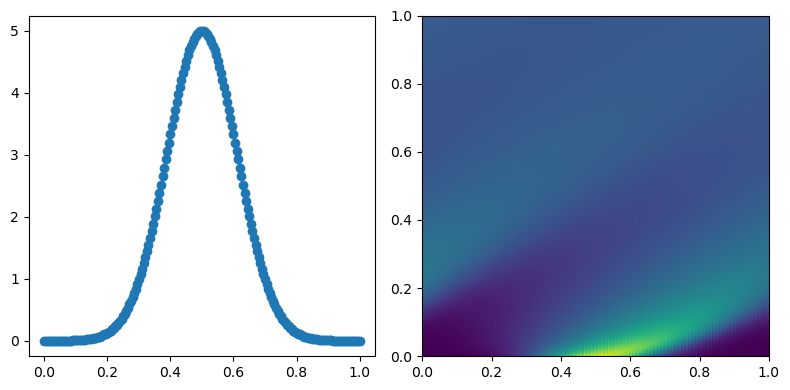

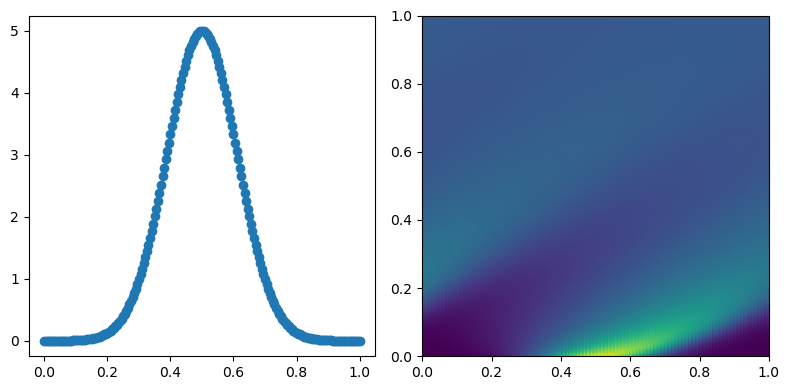

In [1]:
import numpy as np
import deepxde.deepxde as dde
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
import time
import torch
import numpy as np
import time
from typing import Callable, Tuple, Union, List, Any
from torch import nn, Tensor
from torch.nn import functional as F
from numpy.typing import ArrayLike

class BurgersSolver(nn.Module):
    def __init__(self, xmax: float = 1, tmax: float = 1, nu: float = 0.1, nx: int = 101, nt: int = 101, upsample: tuple[int, int] = (1, 5), umax: float = 5):
        """
        The settings for the Burgers equation solver.

        Args:
            xmax (float, optional): the length of x-axis. Defaults to 1.
            tmax (float, optional): the length of t-axis. Defaults to 1.
            nu (float, optional): the viscosity of the fluid. Defaults to 0.1.
            nx (int, optional): the number of x grid. Defaults to 101.
            nt (int, optional): the number of t grid. Defaults to 101.
            upsample (tuple[int, int], optional): (up_x, up_t), affecting the precision of the solution, must satisfy some conditons. Defaults to None.
            `up_x` should be bigger than `xmax / (nx * nu)` because of the shapeness of the shock wave. `up_t` should fulfill the stability condition (CFL), which is `CFL = nx * umax * tmax / nt / xmax < 1`.
            umax (float, optional): the maximum of the initial condition. Defaults to 5.
        """
        super().__init__()
        self.xmax = xmax
        self.tmax = tmax
        self.nu = nu
        if upsample is None:
            #TODO: automatically choose upsample
            # 0.1 -> (1, 100), 0.01 -> (1, 10), 0.001 -> (1 , 10)
            upx = max(1, math.ceil((xmax / (nx -1)) / nu))
            upt = max(1, math.ceil(10 / nu * upx * (nx - 1) / (nt -1)))
            upsample = (upx, upt)
        self.upsample = upsample
        print(self.upsample)
        self.nx = nx
        self.nt = nt
        self.mx = (nx -1) * upsample[0] + 1
        self.mt = (nt - 1) * upsample[1] + 1
        self.register_buffer("x", torch.linspace(0, xmax, self.mx))
        self.register_buffer("t", torch.linspace(0, tmax, self.mt))
        self.dx = xmax / (self.mx - 1)
        self.dt = tmax / (self.mt - 1)
        self.c1 = self.dt / (2 * self.dx)
        self.c2 = self.nu * self.dt / self.dx ** 2
        
        I = torch.eye(self.mx - 1)
        I1 = torch.roll(I, 1, 0)
        I2 = torch.roll(I, -1, 0)
        self.register_buffer("A", (I2 - I1))
        self.register_buffer("B", (I1 + I2 - 2 * I))
    
    @torch.no_grad()
    def forward(self, u0):
        u0 = torch.as_tensor(u0, device=self.x.device, dtype=self.x.dtype)
        batch = u0.shape[0]
        u0 = interp_nd(u0, self.x[:, None] * 2 - 1)
        u = torch.empty(batch, self.mx - 1, self.mt, device=self.x.device, dtype=self.x.dtype)
        u[...,0] = u0[..., :-1]
        for n in range(0, self.mt - 1):
            u0 = u[..., n]
            u1 = u0.roll(1, dims = 1)
            u2 = u0.roll(-1, dims = 1)
            u[..., n + 1] = u0 - self.c1 * (u2 - u1) * u0 + self.c2 * (u1 + u2 - 2 * u0)
            
        u = torch.cat([u, u[:, (0,), :]], dim = 1)
        
        return u[:, ::self.upsample[0], ::self.upsample[1]]

# -------------------------- nd grid sample --------------------------
# Adapted from https://github.com/luo3300612/grid_sample1d, support 1D, 2D, 3D grid
def grid_sample(input: Tensor, 
                grid: Tensor, 
                mode:str = "bilinear", 
                padding_mode:str = "zeros", 
                align_corners: bool | None = None
                ) -> Tensor:
    if grid.shape[-1] == 1:
        assert mode in ["nearest", "linear"], "1D grid only support nearest and linear mode"
        input = input.unsqueeze(-1)
        grid = grid.unsqueeze(1)
        grid = torch.cat([-torch.ones_like(grid), grid], dim=-1)
        out_shape = [grid.shape[0], input.shape[1], grid.shape[2]]
        return F.grid_sample(input, grid, 
                             mode= "bilinear" if mode == "linear" else mode, 
                             padding_mode=padding_mode, 
                             align_corners=align_corners).view(*out_shape)
    else:
        return F.grid_sample(input, grid, mode=mode, padding_mode=padding_mode, align_corners=align_corners)

def interp_nd(grid: Tensor, 
              points: Tensor, 
              mode: str = "linear", 
              align_corners: bool = True, 
              padding_mode: str = "border"
              ) -> Tensor:
    """
    Using torch to do interpolation. Support 1D, 2D, 3D grid. And for grid inputs, points can be unbatched or batched, but for unbatched grid inputs, points must be unbatched.

    Args:
        grid (torch.Tensor): the input function, shape `B, (C,) D, (H,) (W,)` for batched input, `(C,) D, (H,) (W,)` for unbatched input, channel dimension is optional.
        points (torch.Tensor): `B, N, dim` for batched input, `N, dim` for unbatched input. the points should be in the range of `[-1, 1]`.
        mode (str, optional): the mode for interpolation. Defaults to "linear".

    Returns:
        torch.Tensor: shape `(B,) (C,) N
    """
    interp_dim = points.shape[-1]
    is_point_batched = points.dim() == 3
    is_grid_batched = grid.dim() > interp_dim
    is_channelled = grid.dim() -1 == is_grid_batched + interp_dim
    
    if not is_channelled:
        grid = grid.unsqueeze(int(is_grid_batched))
        
    if not is_grid_batched:
        grid = grid.unsqueeze(0)
    if not is_point_batched:
        points = points.unsqueeze(0).expand(grid.shape[0], -1, -1)
    
    for _ in range(interp_dim - 1):
        points = points.unsqueeze(-2)
    
    grid = grid_sample(grid, points, mode=mode, padding_mode=padding_mode, align_corners=align_corners)
    for _ in range(interp_dim - 1):
        grid = grid.squeeze(-1)
    
    if not is_grid_batched:
        grid = grid.squeeze(0)
    
    if not is_channelled:
        grid = grid.squeeze(int(is_grid_batched))
    
    return grid

def solve_Burgers(XMAX, TMAX, NX, NT, NU, u0):
    """
   Returns the velocity field and distance for 1D non-linear Burgers equation, XMIN = 0, TMIN=0
   """
    assert 1 / NX / NU < 0.5, f"Stability condition not met"
    DT = TMAX / (NT - 1)
    DX = XMAX / (NX - 1)

    # Initialise data structures
    u = np.zeros((NX - 1, NT))

    # Initial conditions
    u[:, 0] = u0[:-1]

    # Periodic boundary conditions
    I = np.eye(NX - 1)
    I1 = np.roll(I, 1, axis=0)
    I2 = np.roll(I, -1, axis=0)
    A = I2 - I1
    B = I1 + I2 - 2 * I
    # Numerical solution
    for n in range(0, NT - 1):
        u[:, n + 1] = u[:, n] - (DT / (2 * DX)) * np.dot(A, u[:, n]) * u[:, n] + NU * (DT / DX ** 2) * np.dot(B, u[:, n])
    u = np.concatenate([u, u[0:1, :]], axis=0)
    return u

func = dde.data.GRF(1, "RBF", 0.1, 1000)
feas = func.random(1)
space = np.linspace(0, 1, 201)[:, None]
vx = func.eval_batch(feas, space)[0] + 0.5
vxt = func.eval_batch(feas, np.linspace(0, 1, 101)[:, None])
vx  = np.exp(-((space - 0.5) * 9)**2/2)[:,0] * 5
vxt = np.exp(-((np.linspace(0, 1, 101) - 0.5) * 9)**2/2)[None, ] * 5
# vxt = func.eval_batch(func.random(10), np.linspace(0, 1, 101)[:, None])
t = time.time()
solver = BurgersSolver(1, 1, 0.1, 101, 101, (2, 200)).cpu()
tu = solver(vxt)[0].cpu().numpy()
print(time.time() - t)
# t = time.time()
# solver = BurgersSolver(1, 1, 0.0001, 101, 101).cpu()
# tu = solver(vxt)[0].cpu().numpy()
# print(time.time() - t)

t = time.time()
solution = solve_Burgers(1, 1, 201, 20001, 0.1, vx)[::2, :: 200]
print(time.time() - t)
x = np.linspace(0, 1, 101)
t = np.linspace(0, 1, 101)
grid = np.meshgrid(t, x, indexing="ij")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.scatter(space[:, 0], vx)
ax2.scatter(grid[0], grid[1], c=tu)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.scatter(space[:, 0], vx)
ax2.scatter(grid[0], grid[1], c=solution)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# solution = solve_Burgers(1, 1, 201, 20001, 0.01, vx)[::2, ::200]
# x = np.linspace(0, 1, 101)
# t = np.linspace(0, 1, 101)
# grid = np.meshgrid(t, x, indexing="ij")

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# ax1.scatter(space[:, 0], vx)
# ax2.scatter(grid[0], grid[1], c=solution)
# ax2.set_xlim(0, 1)
# ax2.set_ylim(0, 1)
# plt.tight_layout()
# plt.show()

# solution = solve_Burgers(1, 1, 201, 200001, 0.01, vx)[::2, ::2000]
# x = np.linspace(0, 1, 101)
# t = np.linspace(0, 1, 101)
# grid = np.meshgrid(t, x, indexing="ij")

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# ax1.scatter(space[:, 0], vx)
# ax2.scatter(grid[0], grid[1], c=solution)
# ax2.set_xlim(0, 1)
# ax2.set_ylim(0, 1)
# plt.tight_layout()
# plt.show()

(1, 2, 200)
(1, 100)
(1, 100)
(1, 99)


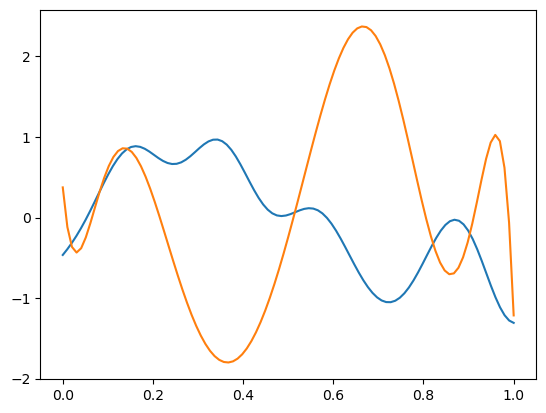

In [16]:
from utils.func import RFF
import numpy as np
from matplotlib import pyplot as plt
# test RFF
rff = RFF(sigma = 10)
feature = rff.random(1)
print(feature.shape)
x = np.linspace(0, 1, 100)
y = rff.eval_one(feature, x)
print(y.shape)
plt.plot(x, y[0])
print(rff.eval_batch(feature, x).shape)

from deepxde.deepxde.data.function_spaces import Chebyshev

che = Chebyshev(N=10)
feature = che.random(1)
x = np.linspace(0, 1, 99)
y = che.eval_one(feature, x)
print(y.shape)
plt.plot(x, y[0])